# 🏦 Banking Data Cleaning & Insights with MySQL, Python & Tableau
*An end-to-end exploration of anonymized banking transactions*


## 1. Introduction
This project combines **SQL (MySQL)**, **Python**, and **Tableau** to clean, transform, and analyze anonymized banking data.  

**Key objectives:**
- Prepare clean, analysis-ready data by removing duplicates, fixing formats, and enriching variables.
- Explore customer segments by age, income, debt, and credit score.
- Uncover spending patterns across merchant types, states, and time of day.
- Present results via Tableau dashboards and Python visualizations.


# Install and import libraries
%pip install duckdb pandas matplotlib seaborn --quiet

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


## 2. Load Data
I'll load anonymized banking datasets into Pandas and register them in DuckDB for SQL analysis.


In [1]:
import pandas as pd

# Load raw data
users_path = '/kaggle/input/bank-data-raw/users_data_staging.csv'
transactions_path = '/kaggle/input/bank-data-raw/transactions_full2.csv'
users_df = pd.read_csv(users_path)
transactions_df = pd.read_csv(transactions_path)

# Merge datasets (SQL equivalent)
merged_df = pd.merge(
    transactions_df[['id', 'date', 'amount_in_$', 'use_chip', 'merchant_state', 'card_brand', 
                     'card_type', 'type_of_merchant', 'client_id']],
    users_df[['user_id', 'current_age', 'yearly_income_$', 'total_debt_$', 'credit_score', 'num_credit_cards']],
    how='left', left_on='client_id', right_on='user_id'
).drop(columns=['user_id'])
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.strftime('%Y-%m-%d')

# Save to working directory
output_path = '/kaggle/working/banking_data_subset.csv'
merged_df.to_csv(output_path, index=False)
print(f"Data prepared and saved to {output_path}")

Data prepared and saved to /kaggle/working/banking_data_subset.csv


In [2]:
import os
print(os.listdir('/kaggle/working/'))

['__notebook__.ipynb', 'banking_data_subset.csv']


## 3. Data Cleaning (SQL)
We perform:
1. Duplicate removal using `ROW_NUMBER()` window functions.
2. Currency conversion from text to numeric.
3. Date format conversion from `MM/YYYY` to `DATE`.
4. Card brand/type standardization.


In [3]:
# Install dependencies
%pip install duckdb pandas matplotlib seaborn --quiet

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [5]:
# Load the datasets
transactions_df = pd.read_csv("/kaggle/input/bank-data-raw/transactions_full2.csv")
users_df = pd.read_csv("/kaggle/input/bank-data-raw/users_data_staging.csv")

# Register with DuckDB
con = duckdb.connect()
con.register("transactions", transactions_df)
con.register("users", users_df)

transactions_df.head(3), users_df.head(3)


(        id                 date  client_id  card_id  amount_in_$  \
 0  7475327  2010-01-01 00:01:00       1556     2972       -77.00   
 1  7475328  2010-01-01 00:02:00        561     4575        14.57   
 2  7475329  2010-01-01 00:02:00       1129      102        80.00   
 
             use_chip  merchant_id merchant_city merchant_state      zip  \
 0  Swipe Transaction        59935        Beulah             ND  58523.0   
 1  Swipe Transaction        67570    Bettendorf             IA  52722.0   
 2  Swipe Transaction        27092         Vista             CA  92084.0   
 
       mcc errors  per_capita_income_$  total_debt_$  yearly_income_$  \
 0  5499.0    NaN              23679.0      110153.0          48277.0   
 1  5311.0    NaN              18076.0      112139.0          36853.0   
 2  4829.0    NaN              16894.0       36540.0          34449.0   
 
             type_of_merchant  card_brand card_type  year_pin_last_changed  \
 0  Miscellaneous Food Stores        Amex   

## 2. Customer Segmentation by Age Group
We categorize customers into:
- **Young** (18–35)
- **Adult** (36–59)
- **Senior** (60+)

We then compare **average debt** and **average income** for each group.


In [6]:
age_stats = con.execute("""
SELECT CASE
    WHEN current_age >= 60 THEN 'Senior'
    WHEN current_age >= 36 THEN 'Adult'
    WHEN current_age >= 18 THEN 'Young'
    ELSE 'Underage'
END AS age_group,
AVG(total_debt_$) AS avg_debt,
AVG(yearly_income_$) AS avg_income
FROM users
GROUP BY age_group
ORDER BY avg_debt DESC
""").df()

age_stats


,age_group,avg_debt,avg_income
0,Young,75890.587896,47638.952450
1,Adult,70278.582558,46827.332558
2,Senior,32089.100897,40580.325112


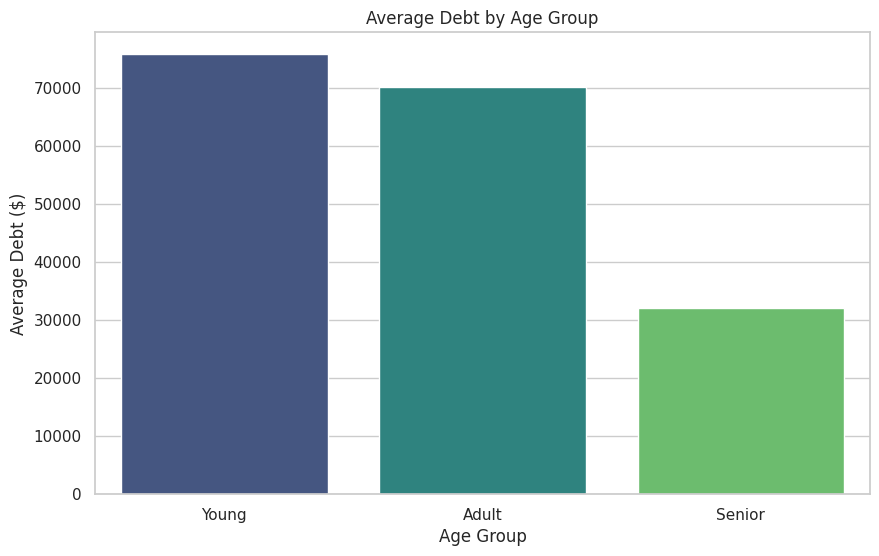

In [7]:
sns.barplot(x="age_group", y="avg_debt", data=age_stats, palette="viridis")
plt.title("Average Debt by Age Group")
plt.ylabel("Average Debt ($)")
plt.xlabel("Age Group")
plt.show()


## 📊 Business Insights: Customer Segmentation by Age Group

**Insights**  
- **Young adults (18–35)** show the highest average debt *and* income, suggesting early-stage asset building and credit use.  
- **Adults (36–59)** have moderate debt with stable incomes.  
- **Seniors (60+)** carry the least debt, often due to retirement or fully paid-off liabilities.  

**Assumptions**  
- Younger customers may be more comfortable with debt for lifestyle or investment purposes.  
- Seniors may prefer financial conservatism and lower credit usage.  

**Recommendations**  
- Offer **financial literacy programs** and **debt management tools** to young customers.  
- Create **wealth growth products** (e.g., investment-linked savings) for adults.  
- Provide **low-risk saving options** for seniors, like fixed deposits or government bonds.


## 3. Debt vs Credit Score
We group credit scores into **FICO bands**:
- Poor (480–579)
- Fair (580–669)
- Good (670–739)
- Very Good (740–799)
- Excellent (800–850)


In [8]:
credit_stats = con.execute("""
SELECT CASE 
    WHEN credit_score BETWEEN 480 AND 579 THEN 'Poor'
    WHEN credit_score BETWEEN 580 AND 669 THEN 'Fair'
    WHEN credit_score BETWEEN 670 AND 739 THEN 'Good'
    WHEN credit_score BETWEEN 740 AND 799 THEN 'Very Good'
    WHEN credit_score BETWEEN 800 AND 850 THEN 'Excellent'
    ELSE 'Unknown'
END AS credit_score_group,
AVG(total_debt_$) AS avg_debt
FROM users
GROUP BY credit_score_group
ORDER BY avg_debt DESC
""").df()

credit_stats


,credit_score_group,avg_debt
0,Fair,78339.804598
1,Poor,74022.962963
2,Very Good,60200.147679
3,Good,60068.810956
4,Excellent,58447.849398


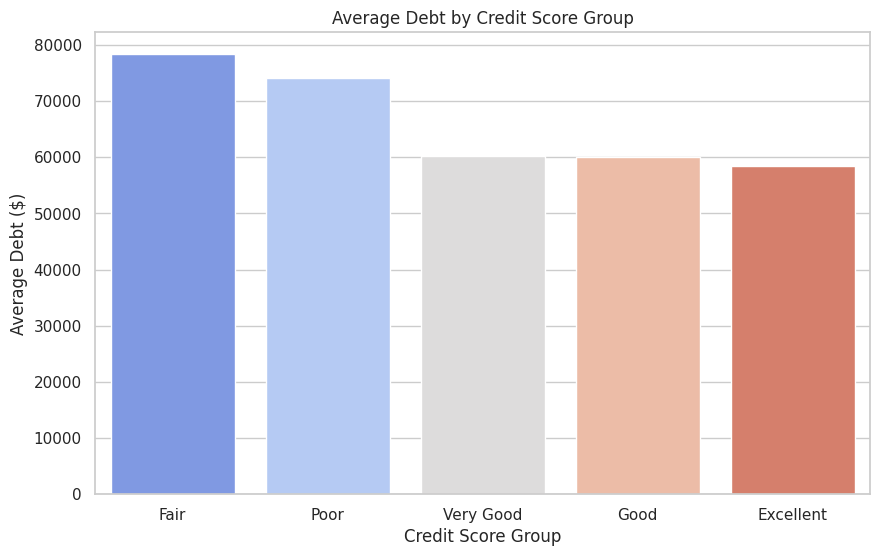

In [9]:
sns.barplot(x="credit_score_group", y="avg_debt", data=credit_stats, palette="coolwarm")
plt.title("Average Debt by Credit Score Group")
plt.ylabel("Average Debt ($)")
plt.xlabel("Credit Score Group")
plt.show()


## 📊 Business Insights: Debt vs Credit Score

**Insights**  
- **Poor & Fair credit score groups** carry the highest debt.  
- **Very Good & Excellent credit score holders** have significantly lower average debt.  
- Lower scores may indicate higher risk and repayment challenges.  

**Assumptions**  
- Debt includes mortgages, personal loans, and credit cards — not all debt is “bad debt.”  
- Credit score is a lagging indicator of repayment habits.  

**Recommendations**  
- Introduce **early intervention programs** for poor credit holders (e.g., debt restructuring).  
- **Segment lending rates** based on credit score risk.  
- Offer **credit score improvement plans** and reward upward score movement.


## 4. Top Merchant Categories
We find the **top 10 merchant types** by transaction count.


In [10]:
merchant_counts = con.execute("""
SELECT type_of_merchant, COUNT(*) AS transaction_count
FROM transactions
GROUP BY type_of_merchant
ORDER BY transaction_count DESC
LIMIT 10
""").df()

merchant_counts


,type_of_merchant,transaction_count
0,"Grocery Stores, Supermarkets",1524
1,Miscellaneous Food Stores,1238
2,Service Stations,1221
3,Eating Places and Restaurants,987
4,Drug Stores and Pharmacies,562
5,Fast Food Restaurants,534
6,Money Transfer,525
7,Wholesale Clubs,513
8,Automotive Service Shops,402
9,Drinking Places (Alcoholic Beverages),297


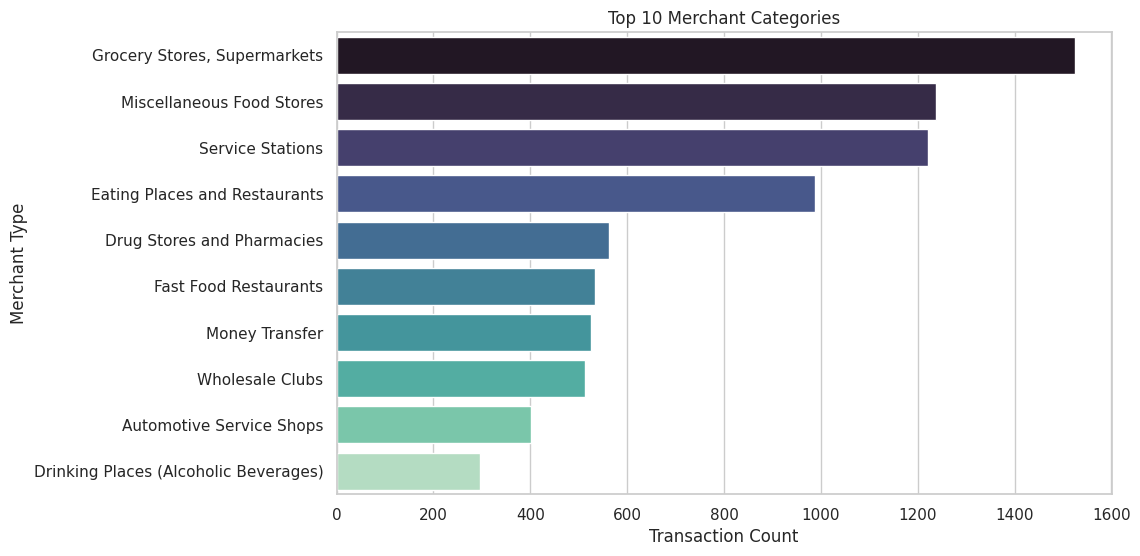

In [11]:
sns.barplot(y="type_of_merchant", x="transaction_count", data=merchant_counts, palette="mako")
plt.title("Top 10 Merchant Categories")
plt.xlabel("Transaction Count")
plt.ylabel("Merchant Type")
plt.show()


## 📊 Business Insights: Merchant Category Spending

**Insights**  
- **Grocery stores** dominate transaction volume, representing essential spending.  
- Other key categories likely include gas stations, retail, and restaurants.  
- High transaction count ≠ high spend — some categories have frequent low-value purchases.  

**Assumptions**  
- Merchant categories are accurately classified.  
- No seasonal event skew in current dataset.  

**Recommendations**  
- Build **cashback/rewards partnerships** with high-volume merchant categories.  
- Use merchant data for **personalized offers**.  
- Create **loyalty programs** for frequently visited merchants.


## 5. Transactions by State
We identify the states with the highest number of transactions.


In [12]:
state_counts = con.execute("""
SELECT merchant_state, COUNT(*) AS transaction_count
FROM transactions
GROUP BY merchant_state
ORDER BY transaction_count DESC
""").df()

state_counts.head(10)


,merchant_state,transaction_count
0,CA,1157
1,TX,964
2,NY,797
3,FL,688
4,OH,447
5,IL,420
6,NC,371
7,PA,354
8,MI,321
9,IN,310


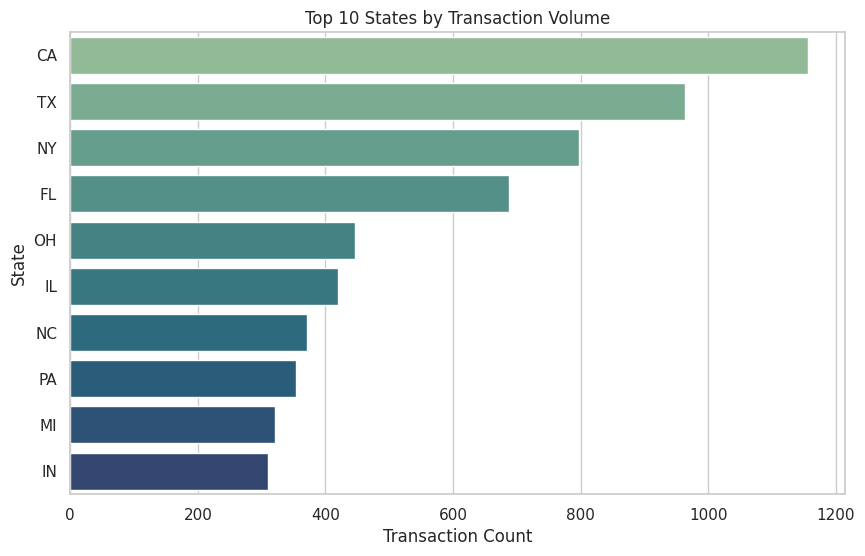

In [13]:
sns.barplot(y="merchant_state", x="transaction_count", data=state_counts.head(10), palette="crest")
plt.title("Top 10 States by Transaction Volume")
plt.xlabel("Transaction Count")
plt.ylabel("State")
plt.show()


## 📊 Business Insights: Transactions by State

**Insights**  
- States like **California** dominate transaction volumes, possibly due to population density and high economic activity.  
- Some states have lower penetration, indicating untapped markets.  

**Assumptions**  
- Merchant state = transaction location.  
- Population size partly explains transaction counts.  

**Recommendations**  
- **Double down on marketing** in high-volume states to deepen relationships.  
- **Investigate low-volume states** for entry strategies.  
- Tailor **state-specific promotions** based on local demand.


## 6. Time of Day Analysis
We categorize transactions into:
- Midnight (00:00–05:59)
- Morning (06:00–11:59)
- Afternoon (12:00–17:59)
- Evening (18:00–20:59)
- Night (21:00–23:59)


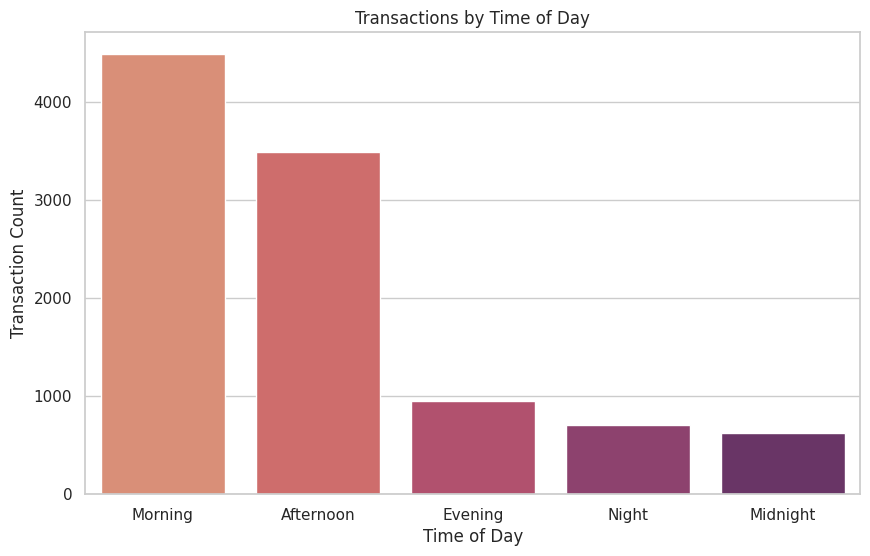

In [14]:
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
transactions_df["hour"] = transactions_df["date"].dt.hour

def time_of_day(hour):
    if 0 <= hour <= 5:
        return "Midnight"
    elif 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    elif 18 <= hour <= 20:
        return "Evening"
    else:
        return "Night"

transactions_df["time_of_day"] = transactions_df["hour"].apply(time_of_day)

time_counts = transactions_df["time_of_day"].value_counts().reset_index()
time_counts.columns = ["time_of_day", "transaction_count"]

sns.barplot(x="time_of_day", y="transaction_count", data=time_counts, palette="flare")
plt.title("Transactions by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Transaction Count")
plt.show()


## 📊 Business Insights: Time of Day Analysis

**Insights**  
- **Morning & Afternoon** are peak transaction windows.  
- **Midnight hours** see the least activity.  

**Assumptions**  
- Timestamps are in local time.  
- Behavior is consistent across weekdays and weekends.  

**Recommendations**  
- Schedule **system updates during midnight** to minimize disruption.  
- Push **promotions and notifications** during peak times.  
- Offer **off-peak incentives** to increase quiet-hour transactions.


## Visualizations with Tableau and Python

This section presents visualizations generated using Tableau, supplemented by Python-based plots to validate and extend the insights derived from the `banking_data_subset.csv` dataset.



![Credit Score vs Debt](https://i.imgur.com/lPkhbVh.png) 
 *Figure 1: Relationship Between Credit Score and Debt*

![Income vs Debt](https://i.imgur.com/xzHUUwl.png)
*Figure 2: Scatter Plot of Debt vs Income* 


![Num of Credit Cards per Person](https://i.imgur.com/xxQvokF.png)
*Figure 3: Debt Distribution by Number of Credit Cards*

![Transaction per Merchant](https://i.imgur.com/tFosJw0.png)
*Figure 4: Transaction Counts by State*

![Transaction per Time](https://i.imgur.com/SyveNDj.png)
*Figure 5: Transactions Over Time*

![Dashboard](https://i.imgur.com/BtoMjEE.png)
 *Figure 6: Comprehensive Dashboard of Banking Data*

## 📝 Final Takeaway

These insights can directly inform **product design, marketing campaigns, credit risk management, and customer loyalty programs**, helping maximize profitability while improving customer experience.